In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from functools import reduce
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('BUBBLE_USDT.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)
df = df[~(df.Volume == 0)]
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2024-05-15 00:01:00,0.012225,0.012268,0.012006,0.012144,102856.52
2024-05-15 00:02:00,0.012144,0.012144,0.012071,0.012113,4833.34
2024-05-15 00:03:00,0.012113,0.012145,0.011963,0.011963,83727.00
2024-05-15 00:04:00,0.011963,0.011963,0.011900,0.011900,16614.13
2024-05-15 00:05:00,0.011900,0.011946,0.011889,0.011889,21205.43


In [3]:
lookback = 25
columns_mass = ['High', 'Low', 'Close', 'Volume']
target_column = 'Close'
INPUT_SIZE = len(columns_mass)

In [4]:
X_train_masses = []
X_test_masses = []
for column in columns_mass:
    data1 = pd.DataFrame(df[column])
    def df_lstm(df, n_steps, Column):
        df = dc(df)
        for i in range(1, n_steps+1):
            df[f'column(t-{i})'] = df[Column].shift(i)
        return df
    
    shifted_df1 = df_lstm(data1, lookback, column)
    df1 = shifted_df1[lookback:]
    time_list = df1.index.tolist()
    
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X = df1.to_numpy()
    x = X[:, 1:]
    y = X[:, :1]
    
    train = X[:int(df.shape[0]*0.8), :]
    test = X[int(df.shape[0]*0.8)::]
    
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    
    X_train = train[:, 1:]
    X_train = dc(np.flip(X_train, axis = 1))
    X_train = X_train.reshape(-1, lookback, 1)
    X_train = torch.tensor(X_train).float()
    
    
    X_test = test[:, 1:]
    X_test = dc(np.flip(X_test, axis = 1))
    X_test = X_test.reshape(-1, lookback, 1)
    X_test = torch.tensor(X_test).float()
    
    
    y_train = train[:, 0]
    y_train = y_train.reshape(-1, 1)
    y_train = torch.tensor(y_train).float()
    
    
    y_test = test[:, 0]
    y_test = y_test.reshape(-1, 1)
    y_test = torch.tensor(y_test).float()
    
    X_train_column = dc(X_train)
    X_test_column = dc(X_test)
    
    X_train_masses.append(X_train_column)
    X_test_masses.append(X_test_column)

column = target_column
data1 = pd.DataFrame(df[column])
def df_lstm(df, n_steps, Column):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f'column(t-{i})'] = df[Column].shift(i)
    return df

shifted_df1 = df_lstm(data1, lookback, column)
df1 = shifted_df1[lookback:]
time_list = df1.index.tolist()


scaler = MinMaxScaler(feature_range=(-1, 1))

X = df1.to_numpy()
x = X[:, 1:]
y = X[:, :1]

train = X[:int(df.shape[0]*0.8), :]
test = X[int(df.shape[0]*0.8)::]

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

y_train = train[:, 0]
y_train = y_train.reshape(-1, 1)
y_train = torch.tensor(y_train).float()

y_test = test[:, 0]
y_test = y_test.reshape(-1, 1)
y_test = torch.tensor(y_test).float()

In [5]:
X_train = np.concatenate(X_train_masses, axis = 2)
X_test = np.concatenate(X_test_masses, axis = 2)
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

In [6]:
from torch.utils.data import Dataset
class LstmDataset(Dataset):
    def __init__(self, X, y):
        self.x  = X
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [7]:
train_data = LstmDataset(X_train, y_train)
test_data = LstmDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size = 124)
test_loader = DataLoader(test_data, batch_size = 124)

for i, batch in enumerate(train_loader):
    print(batch[0].shape)
    break

torch.Size([124, 25, 4])


In [8]:
class LSTM_WOF(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, X):
        batch_size = X.size(0)
        device = X.device
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(X, (h0, c0))
        out = self.linear(out[:, -1, :])

        return out


model = LSTM_WOF(input_size = INPUT_SIZE, hidden_size = 75, num_layers = 1)
model

LSTM_WOF(
  (lstm): LSTM(4, 75, batch_first=True)
  (linear): Linear(in_features=75, out_features=1, bias=True)
)

In [24]:
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [25]:
def training():
    model.train()
    
    for batch_index, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0], batch[1]

        outp = model(X_batch)

        loss = criterion(outp, y_batch)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

def validating():
    model.eval()
    for batch in test_loader:
        optimizer.zero_grad()
        
        X_batch, y_batch = batch[0], batch[1]

        with torch.no_grad():
            outp = model(X_batch)
            loss = criterion(outp, y_batch)

In [27]:
for epoch in range(num_epochs):
    training()
    # validating()
    print(epoch+1)

1
2
3
4
5
6
7
8
9
10


In [28]:
model.eval()
with torch.no_grad():
    y_pred = model.forward(X_test)

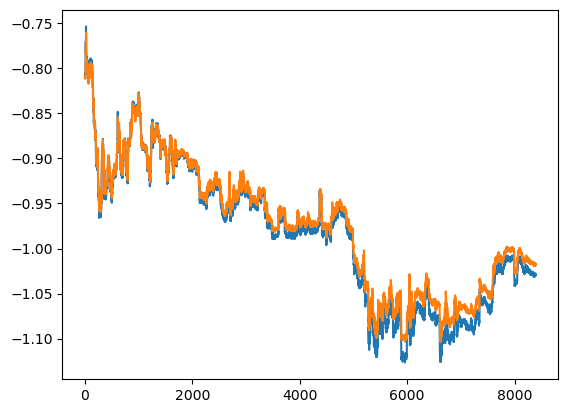

In [29]:

plt.plot(y_test)
plt.plot(y_pred)
plt.show()